In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Tue Jul 12 17:32:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive

# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/drive')



Mounted at /content/drive


In [15]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

Saving test.jpg to test.jpg


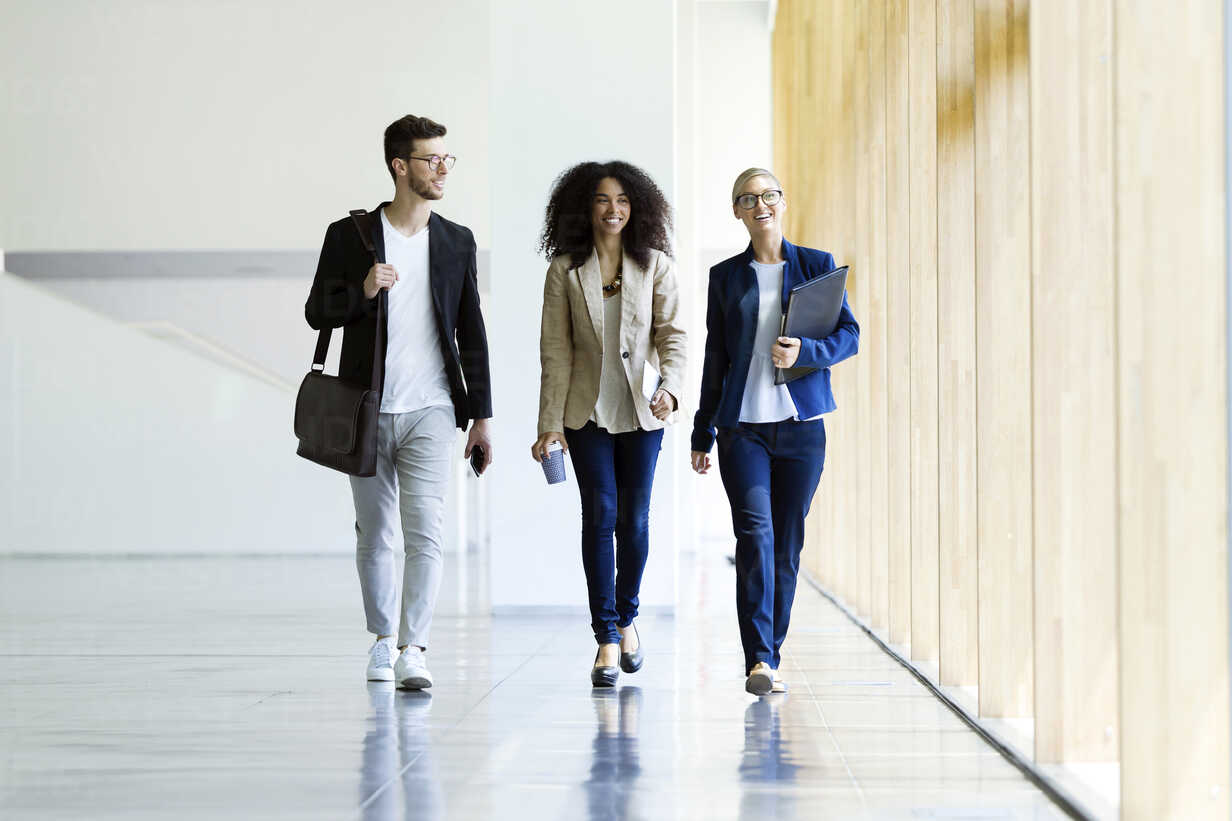

In [16]:

Image('test.jpg')

images: 260 - masks: 260
x_train: 208 - y_train: 208
x_test: 52 - my_test: 52
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
              

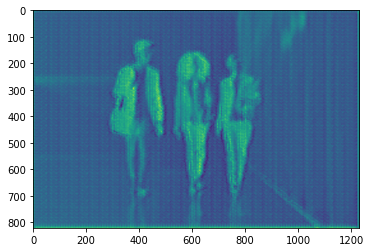

In [10]:
import cv2
import os
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from glob import glob
from sklearn.model_selection import train_test_split

# images dimension
img_width = 256
img_height = 256
img_channels = 3

# img=cv2.imread("test.jpeg")
# img = cv2.resize(img ,( 512 ,512))
# cv2.imshow("img" , img)
# cv2.waitKey(0)

#=====================================================
#=================  build model  =====================

inputs =tf.keras.layers.Input((img_width , img_height, img_channels))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# contracting path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer=, loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

#=============================================================
# =====================  preparing data  =====================
dataset_path = 'datasets'
imgs= sorted(glob("/content/drive/My Drive/U_net/datasets/images/*.jpg"))
masks= sorted(glob("/content/drive/My Drive/U_net/datasets/masks/*.png"))
print(f'images: {len(imgs)} - masks: {len(masks)}')

x_train, x_test= train_test_split(imgs, test_size= 0.2 , random_state=123)
y_train, y_test= train_test_split(masks, test_size= 0.2 , random_state=123)
print(f'x_train: {len(x_train)} - y_train: {len(y_train)}')
print(f'x_test: {len(x_test)} - my_test: {len(y_test)}')

# reshape images
def imgs_read(imgs):
    x= cv2.imread(imgs, cv2.IMREAD_COLOR)
    x= cv2.resize(x, (256,256))
    x= x/255.0
    x= x.astype(np.float32)
    return x

# reshape masks
def masks_read(imgs):
    y= cv2.imread(imgs, cv2.IMREAD_GRAYSCALE)
    y=cv2.resize(y, (256,256))
    y= y/255.0
    y= y.astype(np.float32)
    ## (255,255) => (255, 255, 1)
    y= np.expand_dims(y, axis=-1)
    return y

# x= imgs_read(x_train[1])
# cv2.imwrite('imgg.png',x)
# y= masks_read(y_train[1])
# cv2.imwrite('imggg.png',y)
def preprocess(img_path, mask_path):
    def f(img_path, mask_path):
        img_path= img_path.decode()
        mask_path= mask_path.decode()

        x= imgs_read(img_path)
        y= masks_read(mask_path)
        return x, y

    img, mask= tf.numpy_function(f, [img_path, mask_path], [tf.float32, tf.float32])
    img.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return img, mask

def tf_dataset(imgs, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((imgs, masks))
    dataset = dataset.shuffle(buffer_size= 300)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

train_dataset= tf_dataset(x_train, y_train, batch=8)
valid_dataset= tf_dataset(x_test, y_test, batch=8)
# for img, mask in train_dataset:
#     print(img.shape , mask.shape)

#====================================================
# ====================  train  ======================
batch= 8
# number of step in every epoch 
train_steps = len(x_train) // batch
if len(x_train) % batch !=0:
    train_steps += 1

# number of step in every epoch   
valid_steps = len(x_test) // batch
if len(x_test) % batch !=0:
    valid_steps += 1

# model parameters, name saved model(unet.h5)
input_shape= (256, 256, 3)
lr= 0.0001
epochs = 10
model_path= "unet.h5" 
csv_path= "data.csv"

#  optimizer & loss & metrics
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
 metrics=[tf.keras.metrics.MeanIoU(num_classes=2),
 tf.keras.metrics.Recall(),
 tf.keras.metrics.Precision()])
model.summary()

# to save trained model
callbacks = [ModelCheckpoint(model_path, monitor="val_loss", verbose=1),
ReduceLROnPlateau(monitor="val_loss", patience= 1, factor=0.1, verbose=1),
CSVLogger(csv_path),
EarlyStopping(monitor="val_loss", patience= 2)]

#  fitting model with images and masks
# model.fit(
#     train_dataset, validation_data= valid_dataset, epochs= epochs,
#     steps_per_epoch= train_steps, validation_steps= valid_steps,callbacks=callbacks)

# model = tf.keras.models.load_model("unet.h5")

#==========================================================
# ======================= test  ===========================
x_test = cv2.imread("/content/drive/My Drive/U_net/datasets/test.jpeg", cv2.IMREAD_COLOR)
h, w, _ = x_test.shape

x=cv2.resize(x_test,(256,256))
# x= x/255.0
x= x.astype(np.float32)
# reshape to batch format
x= np.expand_dims(x,axis=0)  # (256,256,3) => (1,256,256,3)

mask_test = model.predict(x)
mask_test = mask_test[0]  # (1,256,256,3) => (256,256,3)

mask_test = (mask_test ) * 255
mask_test = mask_test.astype(np.float32)
mask_test = cv2.resize(mask_test,(w, h))
path='test_images'
# images/1.png
# name = path.split("/")[-1]  ## ["images", "1.png"]
cv2.imwrite("/content/drive/My Drive/U_net/datasets/test_mask.jpg", mask_test)
# cv2.imshow("test_mask", mask_test)
# cv2.waitKey(0)


plt.imshow(mask_test)
plt.show()


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

torch.Size([1, 21, 508, 508])


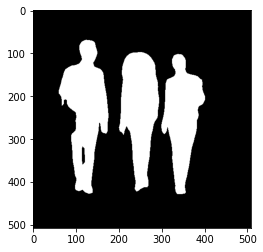

during running time:  0:00:12.538649


In [11]:
from datetime import datetime
start = datetime.now()
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import models 
import torch
from scipy import ndimage

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

img = Image.open("/content/drive/My Drive/U_net/datasets/test.jpeg")
trf = T.Compose([T.Resize(512), T.CenterCrop(508), T.ToTensor(), T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

# Define the helper function
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),
               (0, 0, 0), (0, 0, 0), (0,0, 0), (0, 0, 10), (0, 0, 0),
               (0, 0,0), (0,0,0), (0, 0, 0), (0, 0, 0), (0,0, 0),
               (0,0, 0), (0, 0, 0), (0, 0, 0), (0,0,0), (255, 255, 255),
               (0, 0, 0), (0,0, 0), (0, 0, 0), (0,0, 0), (0, 0,0)])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

out = fcn(inp)['out']
print (out.shape)

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
rgb = decode_segmap(om) 
plt.imshow(rgb)
plt.show()

print('during running time: ', datetime.now() - start)